In [3]:
import skimage
import matplotlib.pyplot as plt
#import zarr # was used but saved the related result into numpy format to reuse
import numpy as np
import pandas as pd
from skimage.measure import regionprops
from skimage.transform import resize
import zarr

Read in from 10x xenium out put file zarr format to retrieve single cell level mask

In [4]:
z2 = zarr.open('../data/masks/1/') # from xenium website output

In [5]:
z2.shape

(40869, 53926)

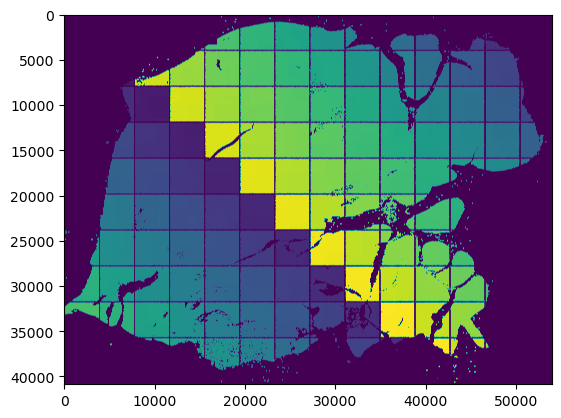

In [6]:
plt.imshow(z2)

In [7]:
z2_np = z2[:,:].copy()
np.save('../data/xton_mask.npy', z2_np)

In [8]:
# reload as numpy
z2 = np.load('../data/xton_mask.npy')
z2.shape

(40869, 53926)

also read in aligned nulcear (dapi) image

In [9]:
import pathlib
from pyometiff import OMETIFFReader
img_fpath = pathlib.Path("../data/morphology_focus.ome.tif")
reader = OMETIFFReader(fpath=img_fpath)
img_array, metadata, xml_metadata = reader.read()

Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'


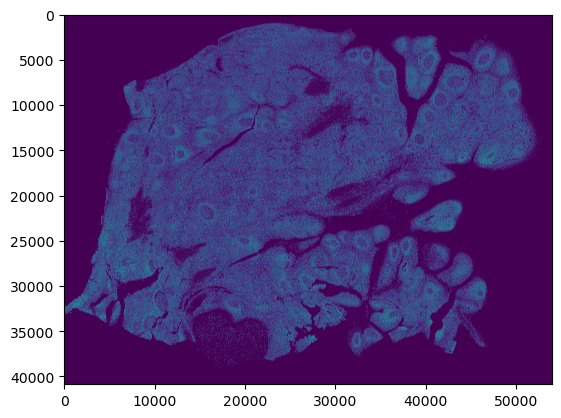

In [10]:
img = img_array
plt.imshow(img)

Start getting single cell level images

In [16]:
df_meta = pd.read_csv('../data/Xton_sub_meta.csv')
df_meta.columns

Index(['cell_id', 'x_centroid', 'y_centroid', 'transcript_counts',
       'control_probe_counts', 'control_codeword_counts',
       'unassigned_codeword_counts', 'deprecated_codeword_counts',
       'total_counts', 'cell_area', 'nucleus_area', 'barcode', 'y_centroid2',
       'n_counts', 'leiden'],
      dtype='object')

In [17]:
df_meta.head()

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,barcode,y_centroid2,n_counts,leiden
0,adkkpojc-1,9079.155273,852.034607,210,0,0,0,0,210,388.343764,18.197969,21061,-852.034607,210.0,9
1,adklbgog-1,9053.489258,836.870728,84,0,0,0,0,84,651.920805,37.840939,21062,-836.870728,84.0,9
2,adklbigp-1,9055.033203,858.775208,70,0,0,0,0,70,85.209847,38.924689,21063,-858.775208,70.0,9
3,adklblhc-1,9071.123047,864.167419,187,0,0,0,0,187,67.418284,29.261251,21064,-864.167419,187.0,9
4,adklcljc-1,9058.196289,865.665100,83,0,0,0,0,83,61.909221,34.092970,21065,-865.665100,83.0,9


In [15]:
def pad_to_square(img):
    h = img.shape[0]
    w = img.shape[1]
    if h < w:
        top_extra = (w - h) // 2
        bottom_extra = w - h - top_extra
        img = np.pad(img, [(top_extra, bottom_extra), (0, 0)])
    elif h > w:
        left_extra = (h - w) // 2
        right_extra = h - w - left_extra
        img = np.pad(img, [(0, 0), (left_extra, right_extra)])
    return img

In [ ]:
from tqdm import tqdm

props = regionprops(z2) # only run once on entire tile
max_height = 64
max_width = 64
count = 0

for i in tqdm(range(df_meta.shape[0])): # loop each cell
    brcd = df_meta.iloc[i,11] # barcode
    brcd = brcd - 1 # correct 0 index in props
    label_in_image = brcd
    bounding_box = props[label_in_image]['BoundingBox']

    ## get whole cell mask
    seg_inside_box = z2[bounding_box[0]:bounding_box[2], bounding_box[1]:bounding_box[3]]
    seg_inside_box2 = seg_inside_box.copy()
    seg_inside_box2[seg_inside_box2 != label_in_image + 1] = 0
    seg_inside_box2[seg_inside_box2 != 0] = 1

    ## produce single cell image
    img_inside_box = img[bounding_box[0]:bounding_box[2], bounding_box[1]:bounding_box[3]]

    ## only get inside mask
    img_inside_box[:,:] = img_inside_box[:,:] * seg_inside_box2

    ## reformat etc
    img_inside_box = pad_to_square(img_inside_box)
    res = np.array(
        [resize(
            img_inside_box[:, :], (max_height, max_width), preserve_range=True
        )]
    ).transpose((1,2,0))

    ## for MUSE formatting
    bb = res[:,:].copy()
    z = np.zeros((64, 64, 1),dtype = bb.dtype)
    out = np.concatenate((bb,z,z),axis=2) # Or np.dstack((a,z))

    ### transfer to 256 scale with save behavior
    thresh = np.quantile(out, 0.9995, axis=(0,1))#.shape
    # cap
    out[:,:,0][out[:,:,0] > thresh[0]] = thresh[0]
    # to 256
    out[:,:,0] = out[:,:,0] / thresh[0] * 255

    #out.shape
    img8 = (out).astype('uint8')
    dird = 'Img_' + str(count) + '.npy'
    np.save('../data/muse_images/' + dird, img8)
    count = count + 1

    if i % 30000 == 1:
        plt.imshow(img8)
        plt.show()